## Transfer Learning MobileNet - Flowers

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [0]:
from matplotlib import style

In [0]:
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image as image
import pandas as pd

In [0]:
style.use('ggplot')

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Flower Dataset Using TensorFlow Datasets

In [7]:
splits = tfds.Split.ALL.subsplit(weighted=(70, 30))

dataset_splits, dataset_info = tfds.load(name='tf_flowers', 
                                         split=splits, 
                                         as_supervised=True, 
                                         with_info=True)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [0]:
training_set, validation_set = dataset_splits

In [9]:
training_set

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [10]:
validation_set

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [12]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
for example_tr in training_set:
  num_training_examples += 1

num_validation_examples = 0
for example_val in validation_set:
  num_validation_examples += 1

print("Number of Flower Classes      : {}".format(num_classes))
print("Number of Training Examples   : {}".format(num_training_examples))
print("Number of Validation Examples : {}".format(num_validation_examples))

Number of Flower Classes      : 5
Number of Training Examples   : 2590
Number of Validation Examples : 1080


In [13]:
for i, example in enumerate(training_set.take(5)):
  print("{} : image_{}_shape : {}".format(i+1, i, example[0].shape))

1 : image_0_shape : (213, 320, 3)
2 : image_1_shape : (240, 176, 3)
3 : image_2_shape : (240, 320, 3)
4 : image_3_shape : (213, 320, 3)
5 : image_4_shape : (240, 240, 3)


### Reformat Images and Create Batches

In [0]:
IMG_RES = 224
BATCH_SIZE = 32

def format_images(image, label):
  image = tf.image.resize(images=image, size=(IMG_RES, IMG_RES))/255.0
  return image, label

In [0]:
train_batches = training_set.shuffle(num_training_examples//4).map(format_images).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_images).batch(BATCH_SIZE).prefetch(1)

In [16]:
image_batch, label_batch = next(iter(train_batches.take(1)))
print(image_batch)
print(label_batch)

tf.Tensor(
[[[[5.01825750e-01 7.05472171e-01 5.65121055e-01]
   [5.01945794e-01 7.03206241e-01 5.74214697e-01]
   [5.02520978e-01 7.14285672e-01 5.88795483e-01]
   ...
   [5.21083355e-01 1.20628193e-01 2.21568510e-01]
   [5.60999274e-01 1.36759654e-01 2.56132334e-01]
   [5.33778727e-01 8.93410593e-02 2.21423820e-01]]

  [[4.97744083e-01 6.99004650e-01 5.69202662e-01]
   [5.00745296e-01 7.03131199e-01 5.74514747e-01]
   [4.98244315e-01 7.10008979e-01 5.84518790e-01]
   ...
   [5.39705813e-01 1.19292632e-01 2.18267187e-01]
   [5.57412922e-01 1.54856816e-01 2.58308172e-01]
   [5.12095153e-01 1.24094866e-01 2.31252715e-01]]

  [[4.94092643e-01 7.05857337e-01 5.74154675e-01]
   [4.93342340e-01 7.05107033e-01 5.79616845e-01]
   [4.92842138e-01 7.04606831e-01 5.79116642e-01]
   ...
   [5.20898402e-01 1.02535971e-01 1.92481965e-01]
   [5.08843601e-01 1.31972671e-01 2.17266798e-01]
   [4.77181077e-01 1.25295192e-01 2.10844412e-01]]

  ...

  [[2.36044433e-02 5.79681806e-02 5.00205970e-05]
   [2

### Simple Transfer Learning With TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(handle=URL, input_shape=(IMG_RES, IMG_RES, 3))

In [18]:
feature_batch = feature_extractor(image_batch)
print(feature_batch)

tf.Tensor(
[[0.0000000e+00 2.3162332e+00 8.3252990e-01 ... 1.2743658e-03
  0.0000000e+00 3.1163058e-01]
 [0.0000000e+00 8.5979879e-02 8.9500584e-02 ... 0.0000000e+00
  1.0268211e-01 0.0000000e+00]
 [5.2195185e-01 5.1880080e-01 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0855126e-02]
 ...
 [0.0000000e+00 1.2327646e-01 5.1629925e-03 ... 2.1678811e-01
  0.0000000e+00 4.1384673e-01]
 [0.0000000e+00 5.6397386e-02 1.4224573e-02 ... 7.5899787e-02
  0.0000000e+00 4.8431498e-01]
 [0.0000000e+00 9.4218832e-01 0.0000000e+00 ... 0.0000000e+00
  6.2238759e-01 0.0000000e+00]], shape=(32, 1280), dtype=float32)


### Freezing the Variables of MobileNet

In [0]:
feature_extractor.trainable = False

### Attach a Classification Head

In [0]:
model_1 = tf.keras.Sequential([
  feature_extractor, 
  tf.keras.layers.Dense(units=5, activation=tf.nn.softmax)
])

### Compile the Model

In [0]:
model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [22]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Fit the Model

In [23]:
EPOCHS = 10

history = model_1.fit(train_batches, 
                      epochs=EPOCHS, 
                      validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 18s 222ms/step - loss: 0.7207 - accuracy: 0.7429 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
81/81 [==============================] - 12s 145ms/step - loss: 0.3687 - accuracy: 0.8838 - val_loss: 0.3803 - val_accuracy: 0.8676
Epoch 3/10
81/81 [==============================] - 12s 147ms/step - loss: 0.2808 - accuracy: 0.9154 - val_loss: 0.3563 - val_accuracy: 0.8750
Epoch 4/10
81/81 [==============================] - 12s 147ms/step - loss: 0.2363 - accuracy: 0.9328 - val_loss: 0.3337 - val_accuracy: 0.8815
Epoch 5/10
81/81 [==============================] - 12s 146ms/step - loss: 0.2000 - accuracy: 0.9448 - val_loss: 0.3485 - val_accuracy: 0.8787
Epoch 6/10
81/81 [==============================] - 12s 145ms/step - loss: 0.1756 - accuracy: 0.9568 - val_loss: 0.3245 - val_accuracy: 0.8935
Epoch 7/10
81/81 [==============================] - 12s 146ms/step - loss: 0.1489 - accuracy: 0.9625 - val_loss: 0.3207 - val_accuracy

### Plot the Training and Validation Graphs

In [29]:
data = {
    "train_acc" : history.history['accuracy'], 
    "train_loss" : history.history['loss'], 
    "val_acc" : history.history['val_accuracy'], 
    "val_loss" : history.history['val_loss']
}

history_df = pd.DataFrame(data=data, index=history.epoch)
display(history_df)

,train_acc,train_loss,val_acc,val_loss
0,0.742857,0.720878,0.843518,0.455797
1,0.883784,0.358861,0.867593,0.380318
2,0.915444,0.279217,0.875000,0.356278
3,0.932819,0.231207,0.881481,0.333713
4,0.944788,0.197768,0.878704,0.348536
5,0.956757,0.173988,0.893519,0.324504
6,0.962548,0.151687,0.893519,0.320688
7,0.966409,0.135752,0.892593,0.323712
8,0.975676,0.122182,0.889815,0.321567
9,0.979537,0.109053,0.896296,0.330951


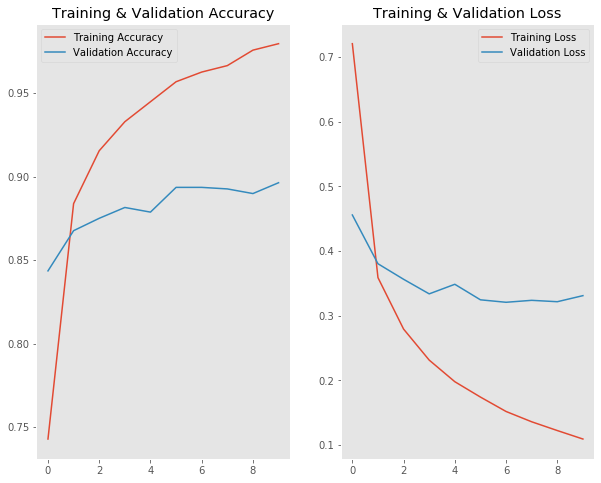

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Training & Validation Accuracy")
plt.plot(history_df.index, history_df['train_acc'], label="Training Accuracy")
plt.plot(history_df.index, history_df['val_acc'], label="Validation Accuracy")
plt.grid(False)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Training & Validation Loss")
plt.plot(history_df.index, history_df['train_loss'], label="Training Loss")
plt.plot(history_df.index, history_df['val_loss'], label="Validation Loss")
plt.grid(False)
plt.legend()

plt.savefig('./foo.png')
plt.show()

### Check Predictions

In [32]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [0]:
predicted_batch = model_1.predict(image_batch)

In [34]:
print(predicted_batch)
print(predicted_batch.shape)

[[1.05065832e-08 4.27983116e-09 2.68082622e-05 1.07988313e-07
  9.99973059e-01]
 [3.66295339e-04 7.78986141e-05 3.77651479e-04 8.81309388e-04
  9.98296916e-01]
 [3.57226580e-02 8.34673829e-03 9.41416681e-01 1.03707972e-03
  1.34768328e-02]
 [9.89919901e-01 1.16360025e-03 8.28558812e-04 7.30313128e-03
  7.84861099e-04]
 [1.46873556e-02 9.84667063e-01 2.05111835e-04 7.44974459e-05
  3.65938497e-04]
 [1.26818037e-02 6.05032546e-04 1.76912479e-04 9.83481109e-01
  3.05516040e-03]
 [4.57331613e-02 9.01800931e-01 1.95071730e-03 4.98320572e-02
  6.83047285e-04]
 [1.50829961e-04 1.11188308e-06 1.04490617e-04 9.99699712e-01
  4.38131392e-05]
 [7.35712871e-02 4.84305463e-04 1.91704899e-01 7.33725965e-01
  5.13640582e-04]
 [9.96462882e-01 2.78599910e-03 3.76052994e-05 1.23966383e-04
  5.89579227e-04]
 [3.04424507e-03 9.94993389e-01 1.61806442e-04 1.76811882e-03
  3.25577930e-05]
 [1.89634273e-04 2.72667938e-04 9.95625079e-01 1.13867136e-04
  3.79889016e-03]
 [5.86667913e-04 9.95915949e-01 1.545671

In [0]:
predicted_ids = np.argmax(predicted_batch, axis=-1)

In [36]:
print(predicted_ids)
print(predicted_ids.shape)

[4 4 2 0 1 3 1 3 3 0 1 2 1 2 0 3 3 2 1 0 0 1 1 0 2 3 2 1 2 0 2 3]
(32,)


In [37]:
print("True Labels      : {}".format(label_batch))
print("Predicted labels : {}".format(predicted_ids))

True Labels      : [4 4 2 0 1 3 1 3 3 0 1 2 1 2 0 3 3 2 1 0 0 1 1 0 2 3 2 1 2 0 2 3]
Predicted labels : [4 4 2 0 1 3 1 3 3 0 1 2 1 2 0 3 3 2 1 0 0 1 1 0 2 3 2 1 2 0 2 3]


In [38]:
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['roses', 'roses', 'tulips', 'dandelion', 'daisy', 'sunflowers',
       'daisy', 'sunflowers', 'sunflowers', 'dandelion', 'daisy',
       'tulips', 'daisy', 'tulips', 'dandelion', 'sunflowers',
       'sunflowers', 'tulips', 'daisy', 'dandelion', 'dandelion', 'daisy',
       'daisy', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'daisy',
       'tulips', 'dandelion', 'tulips', 'sunflowers'], dtype='<U10')

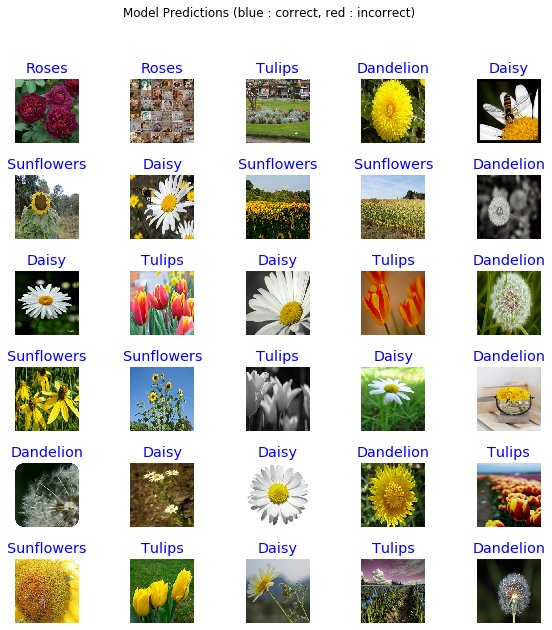

In [43]:
plt.figure(figsize=(10, 10))
plt.suptitle("Model Predictions (blue : correct, red : incorrect)")

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace=0.5)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.grid(False)
  plt.axis('off')

plt.show()